In [44]:
%load_ext autoreload
%autoreload 2
%run ./initializer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) already exists in sys.path


In [45]:
import polars as pl
from datetime import datetime, date
import pandas as pd
from matplotlib import pyplot as plt
from data_loading import DataLoader

In [46]:
data_loader = DataLoader()
df = data_loader.load_and_transform_data("12h")

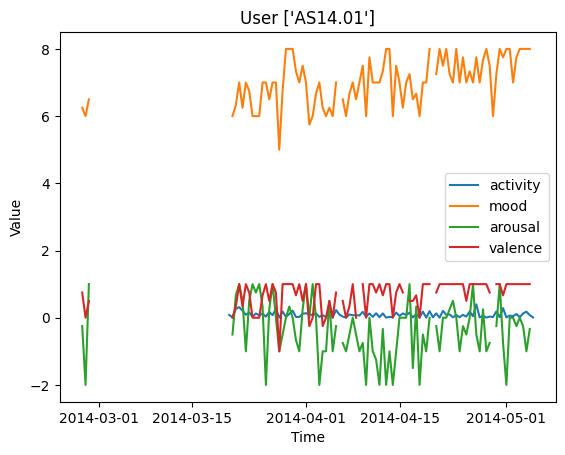

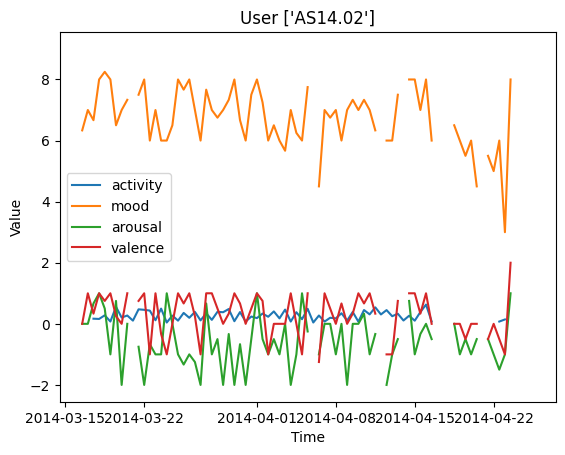

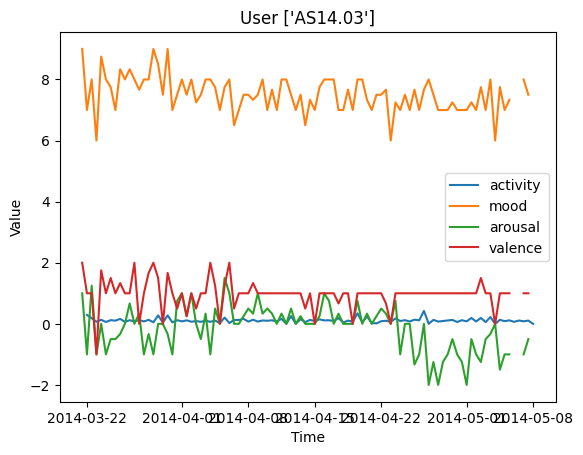

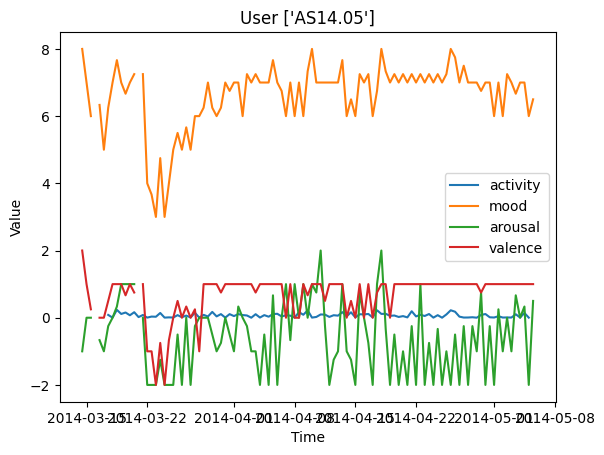

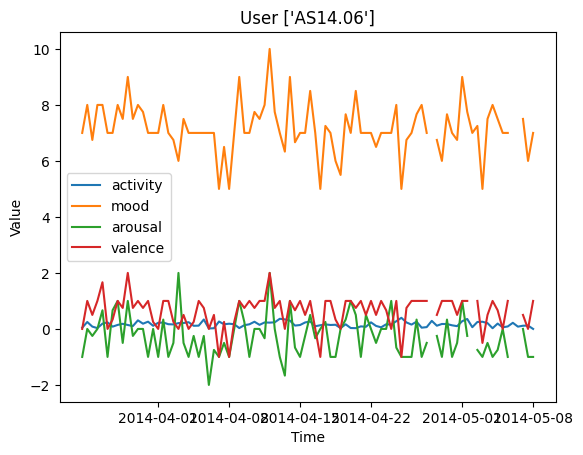

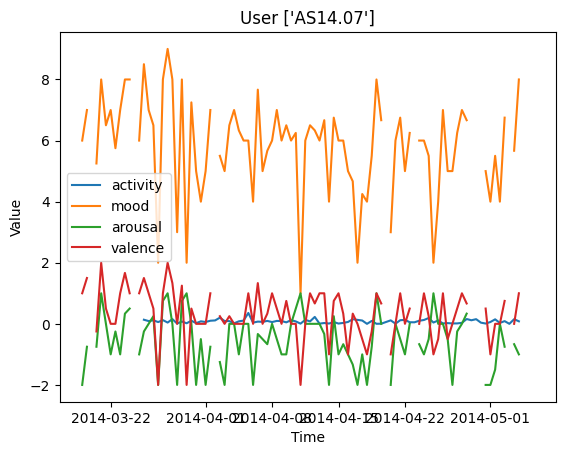

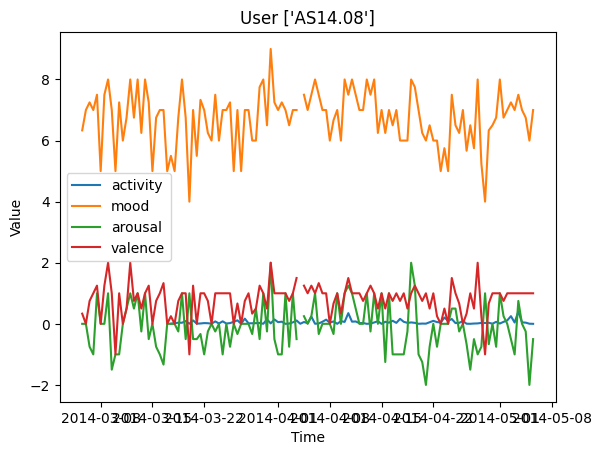

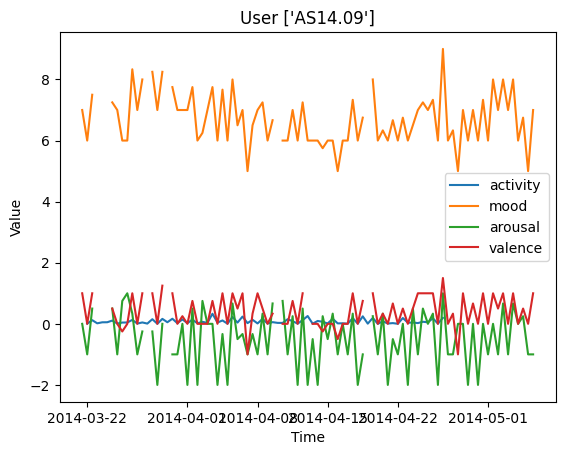

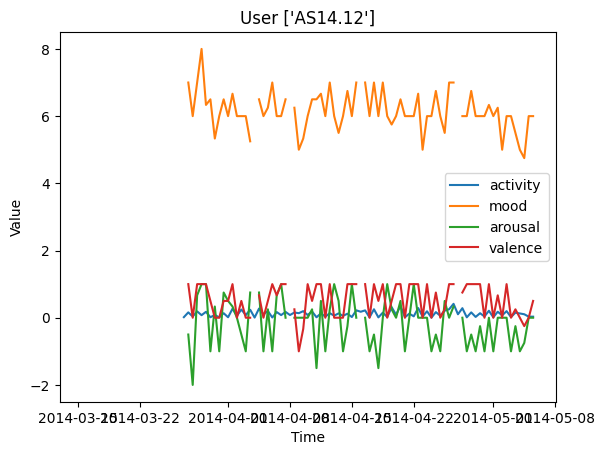

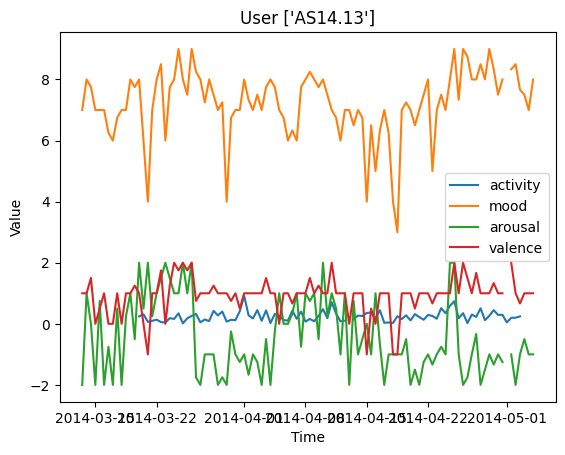

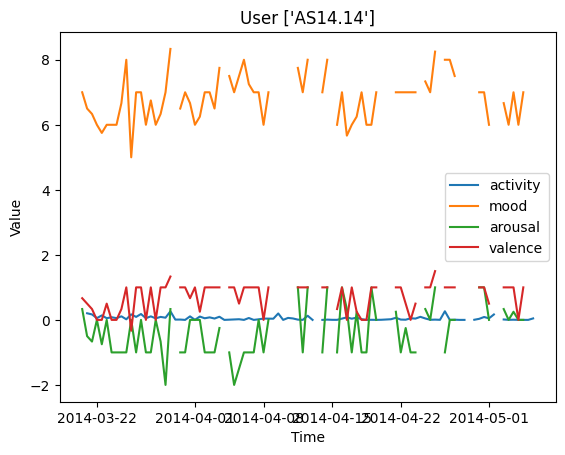

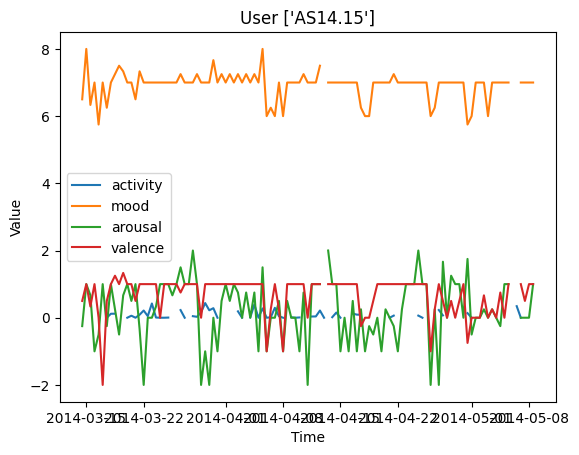

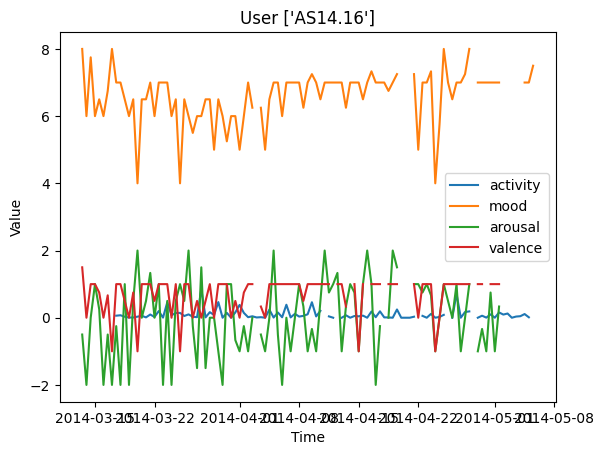

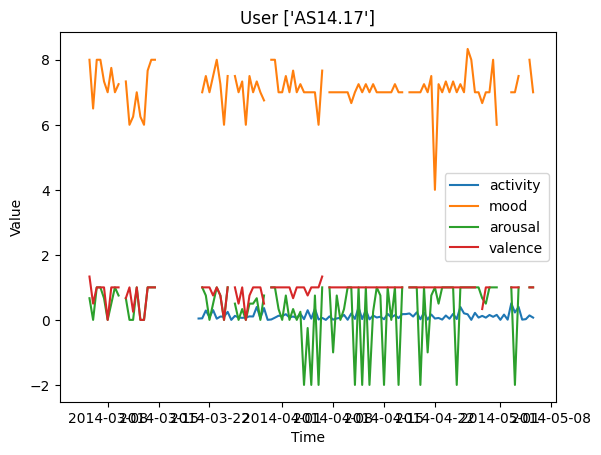

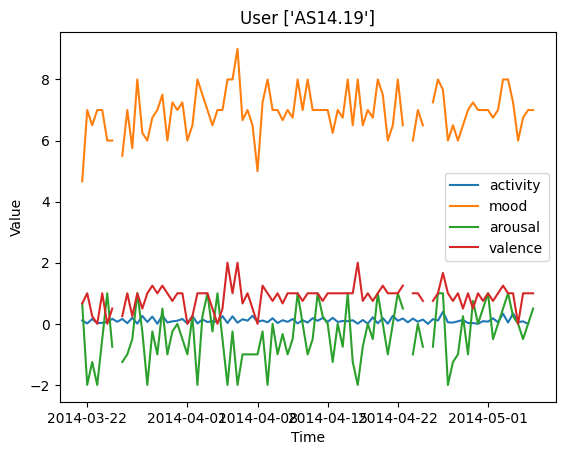

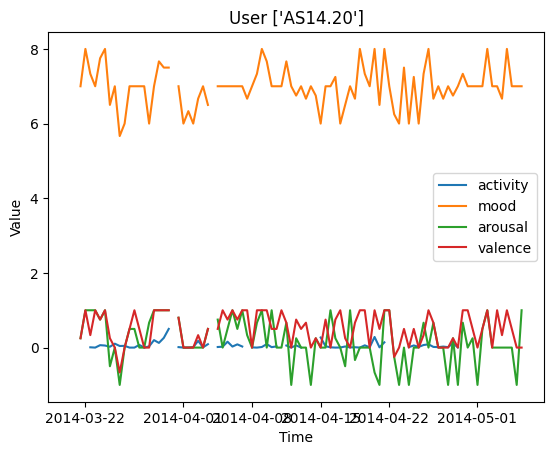

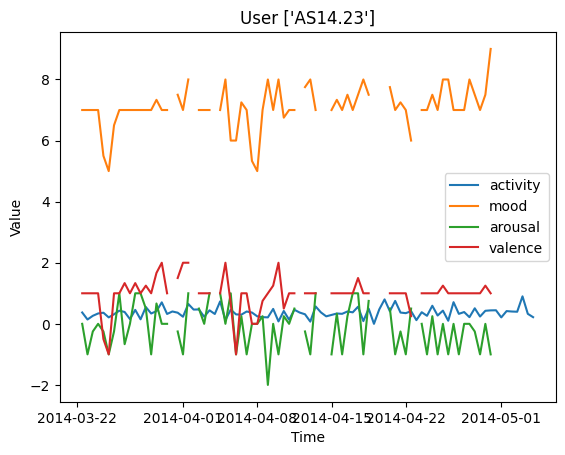

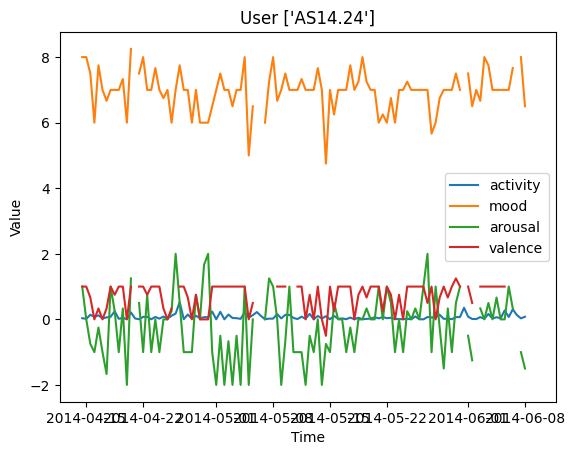

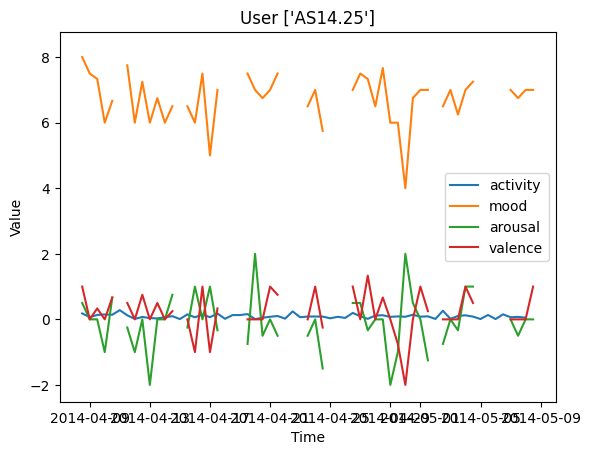

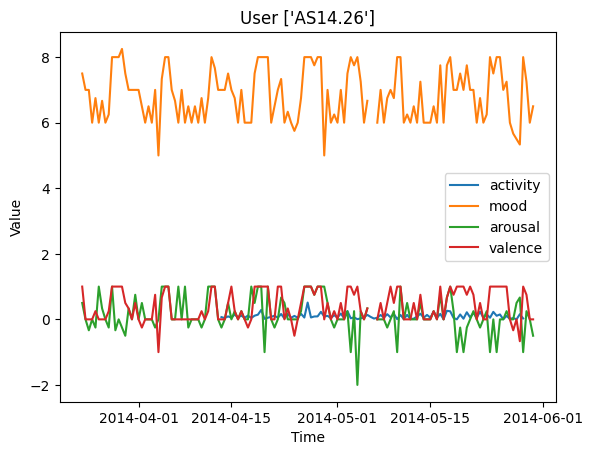

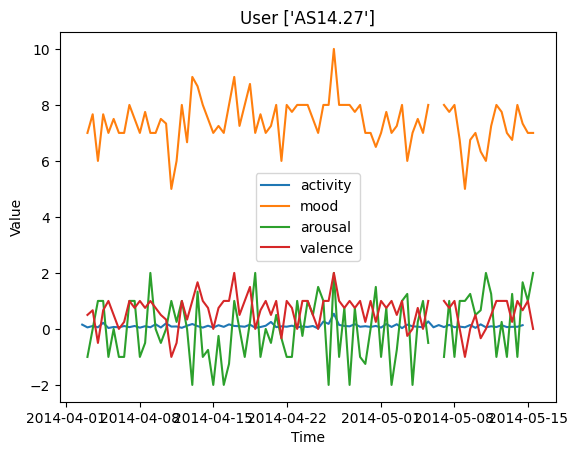

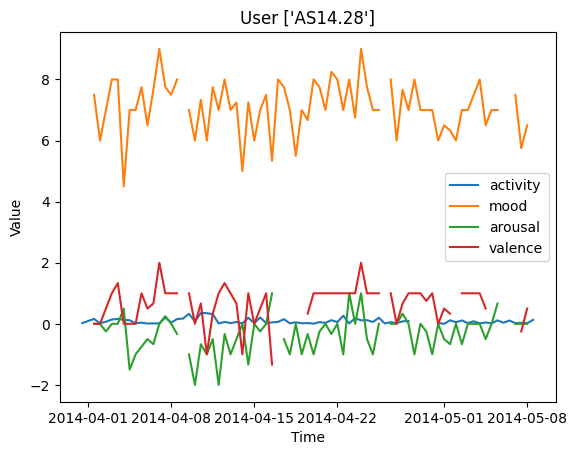

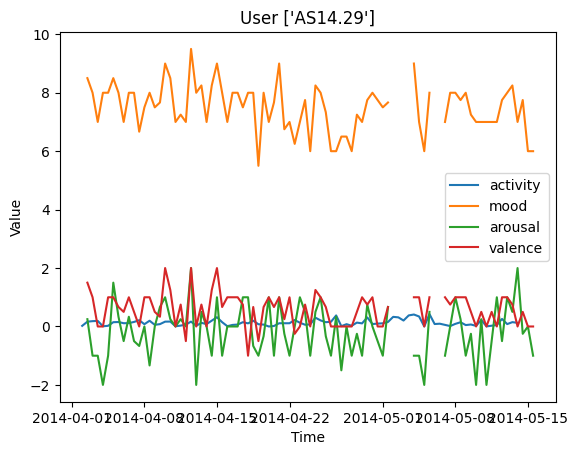

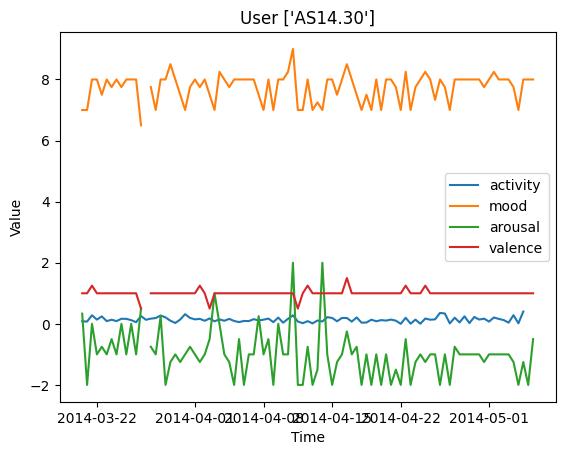

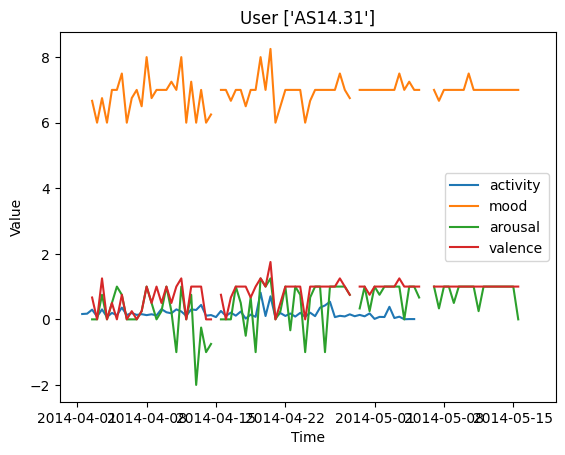

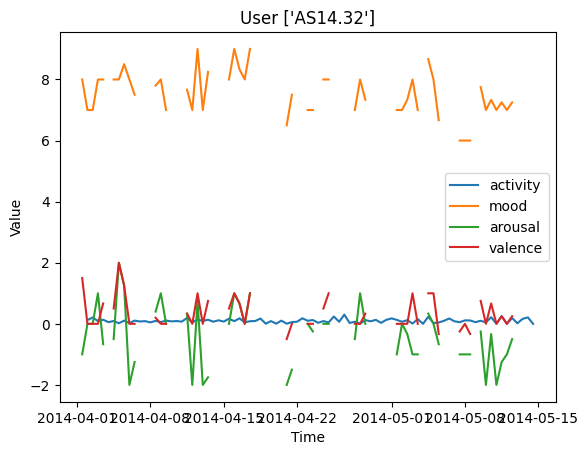

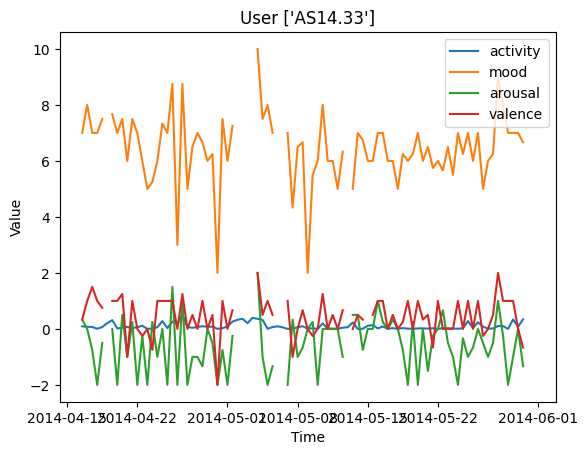

In [47]:
for i in df.sort("id").select("id").unique().to_numpy():
    df_filter = df.filter(pl.col("id") == i)
    df_filter_pd = df_filter.to_pandas()
    df_filter_pd = df_filter_pd.set_index("truncated_time")
    plt.plot(df_filter_pd.index, df_filter_pd["activity"], label="activity")
    plt.plot(df_filter_pd.index, df_filter_pd["mood"], label="mood")
    plt.plot(df_filter_pd.index, df_filter_pd["circumplex.arousal"], label="arousal")
    plt.plot(df_filter_pd.index, df_filter_pd["circumplex.valence"], label="valence")
    plt.title(f"User {i}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()